# **1. Importar Librerías**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import random

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer

import IPython.display as display
from PIL import Image
import io

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, Flatten, MaxPooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# **2. Perfilamiento y Entendimiento de los Datos**

## **2.1. Lectura de los Datos**

Primero, se debe establecer la conexión con Google Drive donde se encuentran alojados los archivos TFRecord con las imágenes (se almacenan aquí por facilidad ya que son 15 archivos, y cada uno de ellos pesa cerca de 560 MB):

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


A continuación, se define la siguiente función que permite permite listar los archivos TFRecord alojados en un directorio de Google Drive:

In [4]:
#Función para cargar los archivos .tfrec desde un directorio del Drive
def list_tf_files_from_drive(path): 
  tf_directory = '/content/drive/My Drive' + os.sep + str(path)
  os.chdir(tf_directory)
  files = os.listdir()
  tffiles = list() 
  for file in files:
    if file.endswith(".tfrec"):
      tffiles.append(file)
  
  return tffiles

Ahora, se procede a realizar la lectura de los archivos TFRecord:

In [5]:
tffiles = list_tf_files_from_drive('Kaggle - Melanoma')
tffiles

['train05-2071.tfrec',
 'train06-2071.tfrec',
 'train10-2071.tfrec',
 'train08-2071.tfrec',
 'train04-2071.tfrec',
 'train01-2071.tfrec',
 'train02-2071.tfrec',
 'train07-2071.tfrec',
 'train00-2071.tfrec',
 'train12-2071.tfrec',
 'train11-2071.tfrec',
 'train09-2071.tfrec',
 'train03-2071.tfrec']

Ahora, se definen las siguientes funciones que permiten leer los archivos TFRecord, y extraer las imagenes junto con su etiqueta o clase:

In [6]:
# Create a dictionary describing the features.
image_feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'image_name': tf.io.FixedLenFeature([], tf.string),
    'target': tf.io.FixedLenFeature([], tf.int64),
}

def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

def load_image_set(file):
    raw_image_dataset = tf.data.TFRecordDataset(file)
    parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
    return parsed_image_dataset

#Funcion para obtener las imagenes y sus etiquetas desde los archivos .tfrec
def load_data(tffiles):
  X_benign = []
  y_benign = []
  X_melanoma = []
  y_melanoma = []

  for file in tffiles:
    records = load_image_set(file)
    for record in records:
      image_raw = record['image'].numpy()
      image = Image.open(io.BytesIO(image_raw))
      image = image.resize((256, 256))
      label = int(record['target'].numpy())
      
      if label == 0  :
        X_benign.append(np.array(image))
        y_benign.append(label)
      else:
        X_melanoma.append(np.array(image))
        y_melanoma.append(label)
    
  return np.array(X_benign), np.array(y_benign), np.array(X_melanoma), np.array(y_melanoma)

Luego, se cargan las imágenes y sus etiquetas o clases desde los archivos TFRecord encontrados anteriormente:

In [7]:
%%time
X_benign, y_benign, X_melanoma, y_melanoma = load_data(tffiles)
print("X_benign: ", X_benign.shape)
print("y_benign: ", y_benign.shape)
print("X_melanoma: ", X_melanoma.shape)
print("y_melanoma: ", y_melanoma.shape)

X_benign:  (26454, 256, 256, 3)
y_benign:  (26454,)
X_melanoma:  (469, 256, 256, 3)
y_melanoma:  (469,)
CPU times: user 13min 22s, sys: 15.3 s, total: 13min 38s
Wall time: 13min 54s


## **2.2. Entendimiento de los Datos**

A continuación, se presenta de forma forma aleatoria una imágen de cada clase:

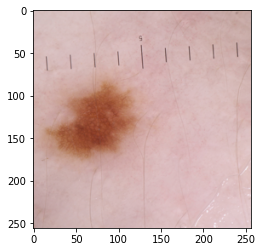

In [8]:
i = random.randint(1, len(X_benign) - 1)
plt.imshow(X_benign[i])

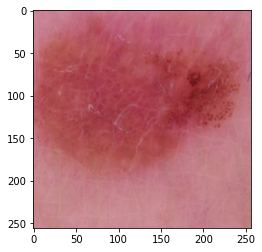

In [9]:
i = random.randint(1, len(X_melanoma) - 1)
plt.imshow(X_melanoma[i])

En la siguiente gráfica, se puede observar la distribución de las imágenes con respecto a las dos clases obtenidas (0: Benign, 1: Melanoma):

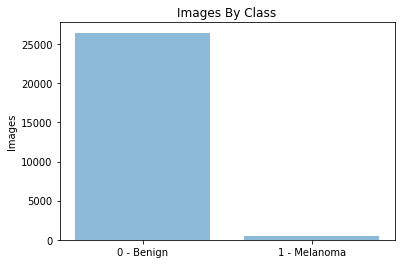

In [10]:
labels = ('0 - Benign', '1 - Melanoma')
y_pos = np.arange(len(labels))
images = [len(y_benign), len(y_melanoma)]

plt.bar(y_pos, images, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('Images')
plt.title('Images By Class')

plt.show()

# **3. Limpieza y Preparación de Datos**

## **3.1. Undersampling**

Como se evidencia en la gráfica anterior, los datos se encuentran altamente desbalanceados. Por esta razón, se procede a aplicar *undersampling* sobre la clase mayoritaria (Benign):

A continuación, se define una función que permite aplicar *undersampling* a la clase mayoritaria:

In [11]:
#Funcion que aplica indersampling sobre la clase mayoritaria
def apply_undersampling(X, y, n_images):
  X_undersampling = random.choices(X, k = n_images)
  y_undersamplig = random.choices(y, k = n_images)
  return np.array(X_undersampling), np.array(y_undersamplig)

Se aplica *undersampling* sobre la clase mayoritaria para mejorar el balance de los datos:

In [12]:
i = X_melanoma.shape[0]
X_benign, y_benign = apply_undersampling(X_benign, y_benign, i)
print("X_benign: ", X_benign.shape)
print("y_benign: ", y_benign.shape)

X_benign:  (469, 256, 256, 3)
y_benign:  (469,)


Ahora, se define la siguiente función que permite unificar los conjuntos de datos de las dos clases obtenidas:

In [13]:
#Funcion que crea un nuevo conjunto de datos uniendo los conjuntos de las dos clases
def unify_classes(X_1, y_1, X_2, y_2):
  X = []
  y = []

  for i in X_1:
    X.append(i)    
  
  for i in X_2:
    X.append(i)
    
  for i in y_1:
    y.append(i)

  for i in y_2:
    y.append(i)  

  return np.array(X), np.array(y)

Finalmente, se unifican los conjuntos de datos:

In [14]:
X, y = unify_classes(X_benign, y_benign, X_melanoma, y_melanoma)
print("X: ", X.shape)
print("y: ", y.shape)

X:  (938, 256, 256, 3)
y:  (938,)


## **3.2. Normalization**

A continuación, se hace la conversión del valor de los pixeles de cada imagen de 0 a 255, a valores entre 0 y 1:

In [15]:
X = X / 255

# **4. Modelamiento**

El primer paso, consiste en realizar la separación de los datos en el conjunto de datos de entrenamiento y el de validación:

In [16]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=33)
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_validation: ", X_validation.shape)
print("y_validation: ", y_validation.shape)

X_train:  (750, 256, 256, 3)
y_train:  (750,)
X_validation:  (188, 256, 256, 3)
y_validation:  (188,)


Ahora, se define la siguiente función que permite construir la red neuronal convolucional:

In [17]:
def build_convolutional_model(hidden_conv_layers, input_filters, hidden_filters, dropout, output_activation):
  input = (256, 256, 3)
  output = 2
  kernel = (2, 2)

  conv_model = Sequential(name='hcl_{0}_if_{1}_hf_{2}_d_{3}_oa_{4}'.format(hidden_conv_layers, input_filters, hidden_filters, dropout, output_activation))
  
  conv_model.add(Conv2D(filters=input_filters, kernel_size=kernel, strides=(1,1), padding='same', input_shape=input, data_format='channels_last'))
  conv_model.add(Activation('relu'))
  conv_model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
  
  if hidden_conv_layers > 0:
    for i in range(hidden_conv_layers):
      conv_model.add(Conv2D(filters=hidden_filters, kernel_size=kernel, strides=(1,1), padding='valid'))
      conv_model.add(Activation('relu'))
      conv_model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

  conv_model.add(Flatten())    
  conv_model.add(Dense(256))
  conv_model.add(Activation('relu'))
  conv_model.add(Dropout(dropout))

  conv_model.add(Dense(output))
  conv_model.add(Activation(output_activation))

  conv_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
  return conv_model

Se instancia el modelo de clasificación que se creará a partir de la función anterior:

In [18]:
model = KerasClassifier(build_fn=build_convolutional_model, epochs=20, verbose=1, shuffle=True)

A continuación, se definen los hiperparámetros que se van a iterar con la función `RandomizedSearchCV`:

In [19]:
param_grid = dict(hidden_conv_layers = [1, 2, 3],
                  input_filters = [16, 32, 64],
                  hidden_filters = [32, 64, 128],
                  dropout = [0.1, 0.3, 0.5, 0.7, 0.9],
                  output_activation = ['sigmoid', 'softmax'])

Se define la siguiente función de pérdida:

In [20]:
def loss_function(y_true, y_pred):
  return accuracy_score(y_true.argmax(axis=-1), y_pred)

In [21]:
score = make_scorer(loss_function, greater_is_better=True)

Se instancia la función `RandomizedSearchCV` que realizará la iteración de los hiperparámetros:

In [22]:
randomized_search = RandomizedSearchCV(model, param_grid, scoring=score, verbose=1, cv = 3, n_iter=8, random_state=20)

Se inicia la iteración de hiperparámetros:

In [23]:
%%time
randomized_search_grid = randomized_search.fit(X_train, tf.keras.utils.to_categorical(y_train, 2))

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
500/500 [==============================] - 8s 15ms/step - loss: 0.8105 - accuracy: 0.5300
Epoch 2/20
500/500 [==============================] - 7s 14ms/step - loss: 0.6995 - accuracy: 0.5460
Epoch 3/20
500/500 [==============================] - 7s 14ms/step - loss: 0.6877 - accuracy: 0.6000
Epoch 4/20
500/500 [==============================] - 7s 14ms/step - loss: 0.6718 - accuracy: 0.6180
Epoch 5/20
500/500 [==============================] - 7s 14ms/step - loss: 0.6294 - accuracy: 0.6140
Epoch 6/20
500/500 [==============================] - 7s 14ms/step - loss: 0.6734 - accuracy: 0.5880
Epoch 7/20
500/500 [==============================] - 7s 14ms/step - loss: 0.6952 - accuracy: 0.5900
Epoch 8/20
500/500 [==============================] - 7s 14ms/step - loss: 0.6390 - accuracy: 0.6520
Epoch 9/20
500/500 [==============================] - 7s 15ms/step - loss: 0.6409 - accuracy: 0.6360
Epoch 10/20
500/500 [==============================] - 7s 15ms/step - loss: 0.6399 - accura

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 60.3min finished


Epoch 1/20
750/750 [==============================] - 9s 12ms/step - loss: 1.1119 - accuracy: 0.5240
Epoch 2/20
750/750 [==============================] - 9s 12ms/step - loss: 0.6969 - accuracy: 0.5547
Epoch 3/20
750/750 [==============================] - 9s 12ms/step - loss: 0.7483 - accuracy: 0.6067
Epoch 4/20
750/750 [==============================] - 9s 12ms/step - loss: 0.6747 - accuracy: 0.6413
Epoch 5/20
750/750 [==============================] - 9s 12ms/step - loss: 0.6356 - accuracy: 0.6493
Epoch 6/20
750/750 [==============================] - 9s 12ms/step - loss: 0.6694 - accuracy: 0.5880
Epoch 7/20
750/750 [==============================] - 9s 12ms/step - loss: 0.6177 - accuracy: 0.6520
Epoch 8/20
750/750 [==============================] - 9s 12ms/step - loss: 0.6094 - accuracy: 0.6533
Epoch 9/20
750/750 [==============================] - 9s 12ms/step - loss: 0.6068 - accuracy: 0.6533
Epoch 10/20
750/750 [==============================] - 9s 12ms/step - loss: 0.7844 - accura

A continuación, se presenta el mejor modelo obtenido a partir de las iteraciones realizadas:

In [24]:
best_model = randomized_search_grid.best_estimator_
best_model.model.summary()

Model: "hcl_3_if_16_hf_128_d_0.3_oa_softmax"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76 (Conv2D)           (None, 256, 256, 16)      208       
_________________________________________________________________
activation_124 (Activation)  (None, 256, 256, 16)      0         
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 127, 127, 128)     8320      
_________________________________________________________________
activation_125 (Activation)  (None, 127, 127, 128)     0         
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_78 (Conv2D)           (N

# **5. Predicción**

A continuación, se obtienen las predicciones del modelo para el conjunto de datos de validación:

In [25]:
model_predictions = best_model.predict(X_validation)
model_predictions

188/188 [==============================] - 1s 3ms/step


array([1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0])

# **6. Validación**

Primero, se obtienen los indices de las imágenes que fueron clasificadas correctamente, y tambien aquellas donde el modelo se equivocó:

In [26]:
model_correct_indexes = np.nonzero(model_predictions == y_validation)[0]
model_incorrect_indexes = np.nonzero(model_predictions != y_validation)[0]

En la siguiente gráfica, se presentan algunas de las imágenes que el modelo clasificó correctamente:

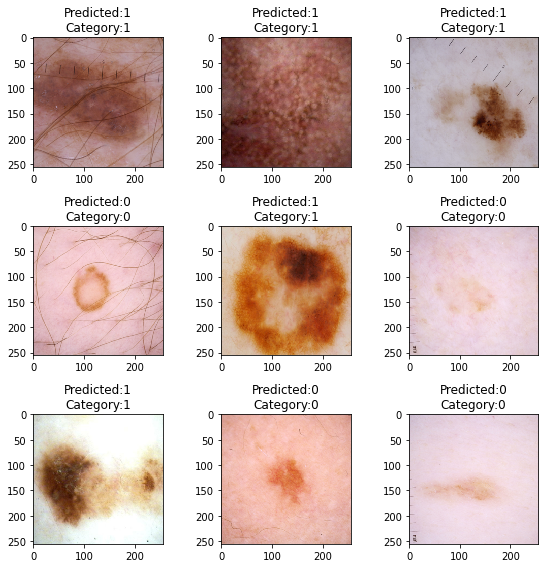

In [27]:
plt.figure(figsize=(8,8))

for i, correct in enumerate(model_correct_indexes[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_validation[correct], cmap='gray', interpolation='none')
    plt.title("Predicted:{}\nCategory:{}".format(model_predictions[correct], y_validation[correct]))

plt.tight_layout()

En la siguiente gráfica, se presentan algunas de las imágenes que el modelo clasificó de forma incorrecta:

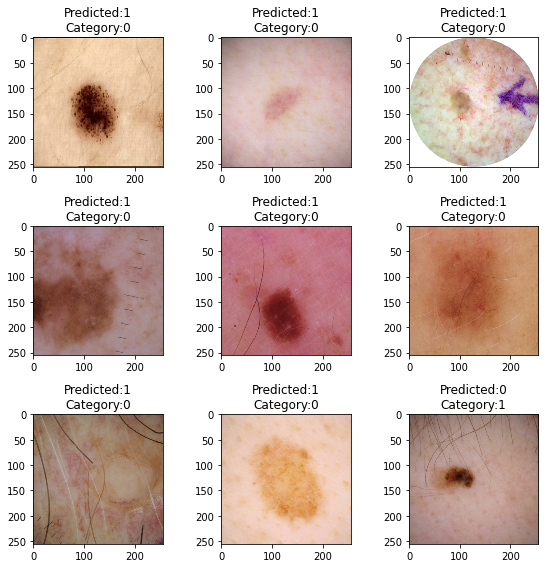

In [28]:
plt.figure(figsize=(8,8))

for i, incorrect in enumerate(model_incorrect_indexes[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_validation[incorrect], cmap='gray', interpolation='none')
    plt.title("Predicted:{}\nCategory:{}".format(model_predictions[incorrect], y_validation[incorrect]))

plt.tight_layout()

Ahora, se presenta el reporte de clasificación obtenido para el modelo:

In [29]:
print(classification_report(y_validation, model_predictions))

              precision    recall  f1-score   support

           0       0.75      0.49      0.60        93
           1       0.63      0.84      0.72        95

    accuracy                           0.67       188
   macro avg       0.69      0.67      0.66       188
weighted avg       0.69      0.67      0.66       188



Finalmente, se presenta la matriz de confusión del modelo:

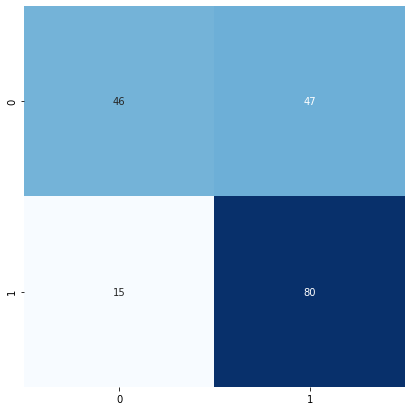

In [30]:
import seaborn as sns

cm = confusion_matrix(y_validation, model_predictions)

df_cm = pd.DataFrame(cm, index = [i for i in np.unique(y_validation)], columns = [i for i in np.unique(y_validation)])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, square=True, annot=True, cmap='Blues',fmt='d', cbar=False)